In [3]:
!apt-get -y install mecab libmecab-dev mecab-ko mecab-ko-dic
!pip install konlpy wordcloud scikit-learn matplotlib pandas
!apt-get -qq install fonts-nanum

E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [5]:
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

def set_korean_font():
    if platform.system() == 'Windows':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin':
        plt.rcParams['font.family'] = 'AppleGothic'
    else:  # Linux/Colab
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        fontprop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = fontprop.get_name()

    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

set_korean_font()


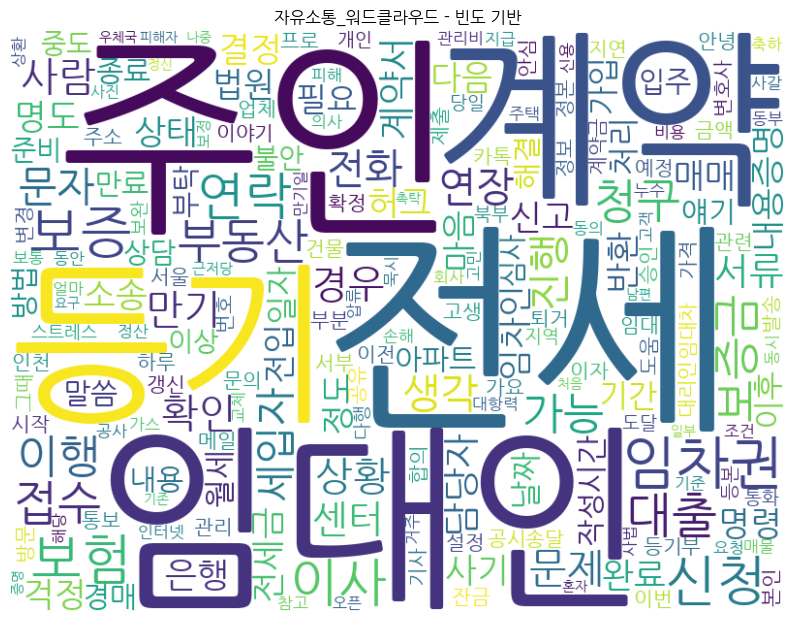

/home/fintech/miniforge3/envs/fintech/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


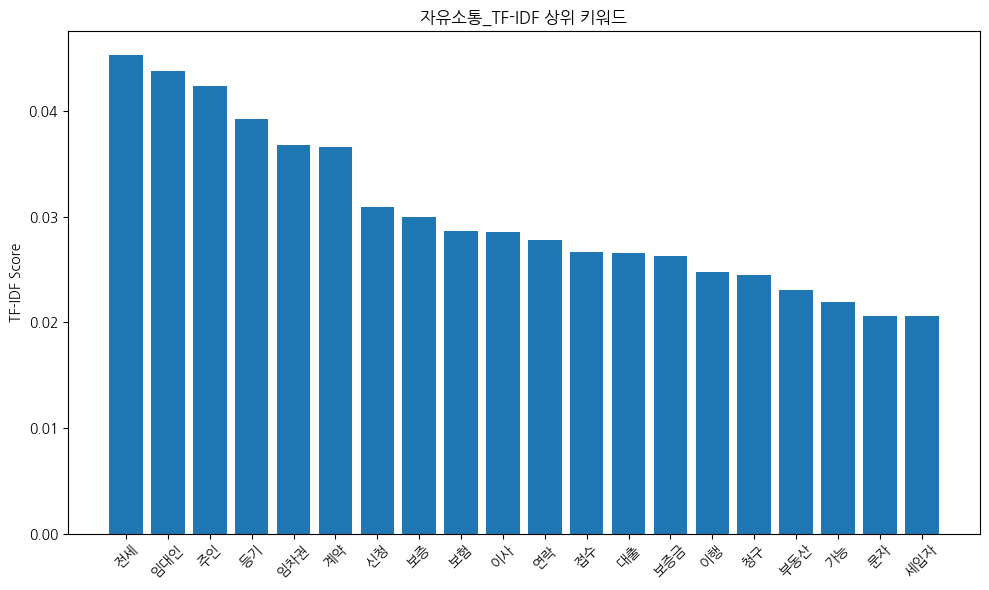

In [30]:
# ✅ 라이브러리 불러오기
import pandas as pd
from konlpy.tag import Mecab
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# ✅ 한글 폰트 설정
font_path = './NanumGothic.ttf'  # 설치된 폰트 사용
font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams['font.family'] = font_name
rcParams['axes.unicode_minus'] = False

# ✅ 1. 데이터 불러오기
df = pd.read_csv('./data/10.자유소통_키워드전처리_완료.csv')  # 🔧 파일 경로 맞게 수정

# ✅ 2. 텍스트 병합 및 정제
df.fillna('', inplace=True)
df['text_all'] = df['제목'] + ' ' + df['본문'] + ' ' + df['댓글']
df = df[df['text_all'].str.strip() != '']  # 빈 행 제거

# ✅ 3. Mecab 초기화
mecab = Mecab()

# ✅ 4. 불용어 설정
custom_stopwords = [
    '안녕하세요', '감사합니다', '문의드립니다', '입니다', '하시고', '부탁드립니다',
    '질문', '답변', '댓글', '되나요', '없어요', '있어요', '합니다', '같아요', '혹시', '안녕'
    '정말', '너무', '그냥', '이런', '저런', '하고요', '하세요', '그러면', '제가', '그리고', '카페', '감사', '주세요'
]

# ✅ 5. 품사 필터링 및 불용어 제거 (안정성 추가)
pos_all = []

for text in df['text_all']:
    try:
        if isinstance(text, str) and text.strip():
            pos_all.extend(mecab.pos(text))
    except Exception as e:
        print(f"❌ 분석 오류 발생: {e}")

# ✅ 6. 키워드 추출
keywords = [word for word, tag in pos_all if tag in ['NNG', 'NNP'] and word not in custom_stopwords and len(word) > 1]

# ✅ 7. 빈도수 분석
word_freq = Counter(keywords)

# ✅ 8. 워드클라우드 시각화
wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=600
)
cloud = wc.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('자유소통_워드클라우드 - 빈도 기반')
plt.show()

# ✅ 9. TF-IDF 분석 함수 정의
def tokenize(text):
    return [word for word, tag in mecab.pos(text)
            if tag in ['NNG', 'NNP'] and word not in custom_stopwords and len(word) > 1]

# ✅ 10. TF-IDF 적용
tfidf = TfidfVectorizer(tokenizer=tokenize)
tfidf_matrix = tfidf.fit_transform(df['text_all'])

words = tfidf.get_feature_names_out()
avg_tfidf = tfidf_matrix.mean(axis=0).A1
tfidf_scores = dict(zip(words, avg_tfidf))

# ✅ 11. TF-IDF 상위 키워드 추출 및 시각화
top_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:20]
words, scores = zip(*top_tfidf)

plt.figure(figsize=(10, 6))
plt.bar(words, scores)
plt.xticks(rotation=45)
plt.title('자유소통_TF-IDF 상위 키워드')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()

